### Compute and store filtered and demodulated velocity fields at each grid point

In [ ]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify


import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [ ]:
from dask.distributed import Client, LocalCluster
#
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=6, cores=6,walltime='04:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=6
#                )
client = Client(cluster)

In [15]:
client.restart()

<Client: 'tcp://10.148.0.94:47398' processes=30 threads=30, memory=558.90 GiB>

In [3]:
dt = 1/24 # hours, sampling interval

# filter properties:
filter_cutoff = 0.5 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

print(f"Default filter cutoff frequency and window size: {filter_cutoff}cpd , {filter_size_pts} points = {filter_size} days ")

Default filter cutoff frequency and window size: 0.5cpd , 480 points = 20 days 


In [4]:
import sstats.sigp_AP as sigp
filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

No handles with labels found to put in legend.


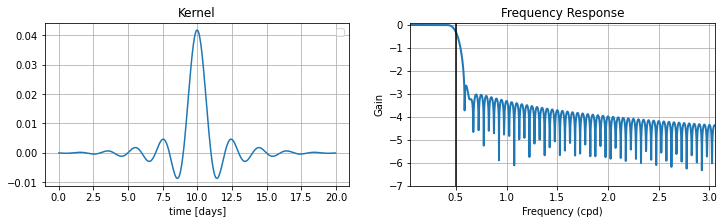

In [5]:
fig, axes = plt.subplots(1,2,figsize=(12,3))

ax = axes[0]
ax.plot(filter_t, filter_h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(float(0.5), color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [6]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
def wrap_filter_low(_ds,dt=dt):
   # h = signal.firwin(_ds.time.size*24, cutoff=[filter_cutoff], pass_zero=True, nyq=1./2/dt, scale=True)
    ds_hat = filt(_ds[v], filter_h,hilbert=False)#.persist()
    ds_hat = ds_hat.rename(v+'_hat').to_dataset()
#    ds_hat = ds_hat.chunk(dict(i=4320//4,j=4320//4))
#    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [7]:
grd = ut.load_grd(V=['XC','YC','CS','SN'])
diags_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
        #ds = xr.merge([ut.load_diagnostic("mean_"+V) for V in ['SSU','SSV']])
ds_mean = xr.open_zarr(diags_dir+'mean.zarr',consolidated=False)[['SSU','SSV']]
ds_mean = xr.merge([grd, ds_mean])
ds_mean = ds_mean.isel(i=slice(0,None, 4), j=slice(0,None, 4))
U_mean =  ds_mean.SSU.rename({'i_g':'i'})*ds_mean.CS - ds_mean.SSV.rename({'j_g':'j'})*ds_mean.SN
V_mean =  ds_mean.SSU.rename({'i_g':'i'})*ds_mean.SN + ds_mean.SSV.rename({'j_g':'j'})*ds_mean.CS
ds_mean['SSU'] = U_mean
ds_mean['SSV'] = V_mean
ds_mean = ds_mean.persist()

/home1/datahome/zcaspar/mit_equinox/mitequinox/utils.py:122: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(ref_data_dir + "grid.zarr", **kwargs)


In [22]:
# Load Eulerian fields
ds =  xr.open_zarr(ut.work_data_dir+'rechunked/SSV_rot.zarr',consolidated=False)
grd = ut.load_grd(consolidated=False)[['XC', 'YC', 'Depth']]#.persist()

In [23]:
import dask

In [24]:
#Select and rechunk (empirical) original dataset
#isel = dict(face=slice(10,None))#dict(j=slice(3800,None))#j=slice(0,4320//10))
dsp = ds.sel(i=slice(0,None,4),j=slice(0,None,4)).isel(time=slice(0,None,3))
dsp['SSV_rot'] = dsp.SSV_rot-ds_mean.SSV.drop(['CS','SN','XC','YC'])
dsp = dsp.chunk({"time": -1,'i':100,'j':100})#.persist()#,'i':100,'j':70
dsp

,Array,Chunk
Bytes,57.84 MiB,39.06 kiB
Shape,"(13, 1080, 1080)","(1, 100, 100)"
Count,4538 Tasks,1573 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,57.84 MiB,39.06 kiB
Shape,"(13, 1080, 1080)","(1, 100, 100)"
Count,4538 Tasks,1573 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [25]:
v = 'SSV_rot'

In [26]:
# Apply wrap_filter on the dataset and store the result for each face (seperated)
import os
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsp, 
                                        wrap_filter_low,
                                        overwrite=True,
                                        suffix="SSV_lpass_filtered_mean1.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
#                                        face=1
                                        j=200
                                       )

6it [16:42, 167.12s/it]


In [38]:
ds_out

,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray


In [14]:
ds_out

,Array,Chunk
Bytes,325.37 GiB,219.73 MiB
Shape,"(13, 1080, 1080, 2880)","(1, 100, 100, 2880)"
Count,1574 Tasks,1573 Chunks
Type,float64,numpy.ndarray


In [34]:
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
_ds = xr.merge([ds_out,grd.sel(i=slice(0,None,4),j=slice(0,None,4))])
_ds

/dev/shm/pbs.9799042.datarmor0/ipykernel_54560/1139983524.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


<xarray.Dataset>
Dimensions:      (face: 13, j: 1080, i: 1080, time: 8640)
Coordinates:
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    SSU_rot_hat  (face, j, i, time) float64 dask.array<chunksize=(1, 100, 100, 8640), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

ValueError: x must be one of None, 'face', 'i', 'j'

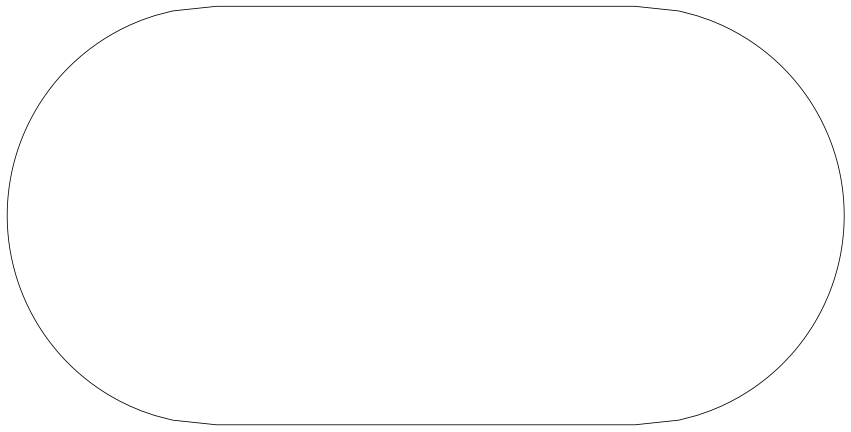

In [35]:
pl.plot_pretty(np.sqrt(_ds.SSU_rot_hat.mean('time')), 
                   infer_intervals=False,land=False,cmap='bone',vmax=0.5,colorbar=False
                  )

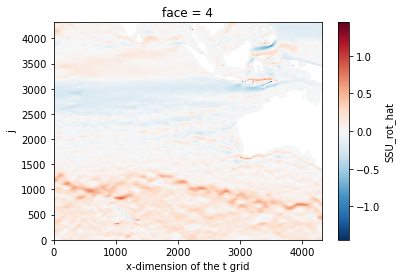

In [38]:
ds_out.mean('time').isel(face=4).SSU_rot_hat.plot()

In [27]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
